In [1]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mainData = pd.read_excel('Online Retail.xlsx')

In [3]:
mainData.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
mainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
mainData.dropna(inplace=True)

In [6]:
mainData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [7]:
CustomerSegment=pd.read_csv('Customer Segments.csv')

In [12]:
Seg_dict=CustomerSegment.set_index('CustomerID').to_dict()['Labels']

In [13]:
mainData['TransactionDate'] = mainData['InvoiceDate'].apply(lambda x: f'{x.year}-{x.month}-1')
mainData['TransactionDate'] = pd.to_datetime(mainData.TransactionDate)                                                     

In [14]:
CLVData=mainData[['CustomerID','InvoiceDate','Quantity','UnitPrice']].copy()

In [15]:
CLVData['Price']=CLVData.Quantity*CLVData.UnitPrice

In [16]:
CLVData['Date']=CLVData.InvoiceDate.apply(lambda x:f'{x.year}-{x.month}-{x.day}')
CLVData['Date']=pd.to_datetime(CLVData['Date'])

In [17]:
CFirstPurchase=CLVData.sort_values(['CustomerID','Date']).groupby('CustomerID').first()

In [18]:
CFirstPurchase['Date'].min()

Timestamp('2010-12-01 00:00:00')

In [19]:
CFirstPurchase['Date'].max()

Timestamp('2011-12-09 00:00:00')

<AxesSubplot:xlabel='Date'>

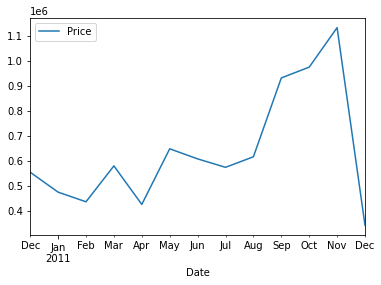

In [20]:
CLVData.set_index('Date')[['Price']].resample('MS').sum().plot()

In [21]:
CLVID_Subset=CLVData[CLVData['CustomerID'].isin(CLVData['CustomerID'].unique()[:10])].groupby(['CustomerID','Date']).sum().reset_index()

In [22]:
N_Days=90
Max_Date=CLVData['Date'].max()
CutOfDate=Max_Date-pd.to_timedelta(N_Days, unit='d')

In [23]:
CustomerOUT=CLVData[CLVData.Date>CutOfDate]
CustomerIN=CLVData[CLVData.Date<=CutOfDate]

In [24]:
Target_Customers=CustomerOUT.drop(['Quantity','InvoiceDate','UnitPrice'],axis=1).groupby('CustomerID').sum().rename({'Price':'Spend_90'},axis=1).assign(Spend_90_flag=1)

In [25]:
Max_Date=CustomerIN.Date.max()
Recency_df=CustomerIN[['CustomerID','Date']].groupby('CustomerID').apply(lambda x: (x['Date'].max()-Max_Date)/pd.to_timedelta(1,unit='day')).to_frame().set_axis(['Recency'],axis=1)
Frequency_df=CustomerIN[['CustomerID','Date']].groupby('CustomerID').count().set_axis(['Frequency'],axis=1)

In [26]:
Price_df=CustomerIN.groupby('CustomerID').aggregate({'Price':{'sum','mean'}}).set_axis(['Price_Sum','Price_Mean'],axis=1)

In [27]:
ML_Data=pd.concat([Recency_df,Frequency_df,Price_df],axis=1
).merge(Target_Customers, right_index=True,left_index=True,how='left').fillna(0)

In [30]:
ML_Data['Labels']=ML_Data.index.map(Seg_dict)

In [32]:
from sklearn.preprocessing import MinMaxScaler

In [33]:
import sklearn
from xgboost import XGBRFClassifier, XGBRFRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error,explained_variance_score, r2_score,confusion_matrix,accuracy_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, RandomForestClassifier,RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

In [34]:
Scaler_F=MinMaxScaler()
Scaler_R=MinMaxScaler()
Scaler_PS=MinMaxScaler()
Scaler_PM=MinMaxScaler()


Scaler_F.fit(ML_Data[['Frequency']])
Scaler_R.fit(ML_Data[['Recency']])
Scaler_PS.fit(ML_Data[['Price_Sum']])
Scaler_PM.fit(ML_Data[['Price_Mean']])

ML_Data['Frequency']=Scaler_F.transform(ML_Data[['Frequency']])
ML_Data['Recency']=Scaler_R.transform(ML_Data[['Recency']])
ML_Data['Price_Sum']=Scaler_PS.transform(ML_Data[['Price_Sum']])
ML_Data['Price_Mean']=Scaler_PM.transform(ML_Data[['Price_Mean']])

In [35]:
#Data Spliting
X=ML_Data.drop(columns=['Spend_90','Spend_90_flag'])
yr=ML_Data.Spend_90
yc=ML_Data.Spend_90_flag

In [36]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [37]:
DR=DecisionTreeRegressor()
DRP=dict(criterion=['mse','mae'],
    max_depth=[None,2,3,4],
    min_samples_split=[2],
    min_samples_leaf=[2],
    max_features=[None],
    random_state=[0],
    max_leaf_nodes=[None]
)

DRGSCV=GridSearchCV(DR,DRP,cv=5,refit=True,verbose=3,scoring='r2')
DRGSCV.fit(X,yr)
print(DRGSCV.best_params_)
print(DRGSCV.best_estimator_)
print(DRGSCV.best_score_)
print(DRGSCV.score(X,yr))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END criterion=mse, max_depth=None, max_features=None, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=2, random_state=0;, score=-3.530 total time=   0.0s
[CV 2/5] END criterion=mse, max_depth=None, max_features=None, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=2, random_state=0;, score=0.449 total time=   0.0s
[CV 3/5] END criterion=mse, max_depth=None, max_features=None, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=2, random_state=0;, score=0.625 total time=   0.0s
[CV 4/5] END criterion=mse, max_depth=None, max_features=None, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=2, random_state=0;, score=0.664 total time=   0.0s
[CV 5/5] END criterion=mse, max_depth=None, max_features=None, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=2, random_state=0;, score=0.334 total time=   0.0s
[CV 1/5] END criterion=mse, max_depth=2, max_features=None, max_leaf_nodes

In [38]:
y=DecisionTreeRegressor(criterion='mae', max_depth=4, min_samples_leaf=2,
                      random_state=0).fit(X,yr).predict(X)
print(mean_absolute_error(yr,y))
print(np.sqrt(mean_squared_error(yr,y)))

403.8772505861665
1991.8104169923902


In [39]:
SR=SVR()
SRP=dict(kernel=['poly'],
    gamma=['scale',1.0,0.01],
    coef0=[1.5,2.0,2.5,5.0],
    degree=[5],
    C=[10,5,1],
)
SRGSCV=GridSearchCV(SR,SRP,cv=5,refit=True,verbose=3,n_jobs=-1,scoring='r2')
SRGSCV.fit(X,yr)
print(SRGSCV.best_params_)
print(SRGSCV.best_estimator_)
print(SRGSCV.best_score_)
print(SRGSCV.score(X,yr))
y=SRGSCV.predict(X)
print(mean_absolute_error(yr,y))
print(np.sqrt(mean_squared_error(yr,y)))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'C': 10, 'coef0': 5.0, 'degree': 5, 'gamma': 1.0, 'kernel': 'poly'}
SVR(C=10, coef0=5.0, degree=5, gamma=1.0, kernel='poly')
0.6249262698150693
0.6945535884628116
406.3536054980106
2175.763082612982


In [40]:
KR=KNeighborsRegressor()
KRP=dict(n_neighbors=range(2,10),
weights=['uniform', 'distance'],
algorithm=['auto'],
p=[1],
n_jobs=[-1])
KRGSCV=GridSearchCV(KR,KRP,cv=5,refit=True,verbose=3,scoring='r2')
KRGSCV.fit(X,yr)
print(KRGSCV.best_params_)
print(KRGSCV.best_estimator_)
print(KRGSCV.best_score_)
print(KRGSCV.score(X,yr))
y=KRGSCV.predict(X)
print(mean_absolute_error(yr,y))
print(np.sqrt(mean_squared_error(yr,y)))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END algorithm=auto, n_jobs=-1, n_neighbors=2, p=1, weights=uniform;, score=-0.097 total time=   0.1s
[CV 2/5] END algorithm=auto, n_jobs=-1, n_neighbors=2, p=1, weights=uniform;, score=0.682 total time=   0.0s
[CV 3/5] END algorithm=auto, n_jobs=-1, n_neighbors=2, p=1, weights=uniform;, score=0.471 total time=   0.0s
[CV 4/5] END algorithm=auto, n_jobs=-1, n_neighbors=2, p=1, weights=uniform;, score=-0.186 total time=   0.0s
[CV 5/5] END algorithm=auto, n_jobs=-1, n_neighbors=2, p=1, weights=uniform;, score=0.303 total time=   0.0s
[CV 1/5] END algorithm=auto, n_jobs=-1, n_neighbors=2, p=1, weights=distance;, score=0.101 total time=   0.0s
[CV 2/5] END algorithm=auto, n_jobs=-1, n_neighbors=2, p=1, weights=distance;, score=0.676 total time=   0.0s
[CV 3/5] END algorithm=auto, n_jobs=-1, n_neighbors=2, p=1, weights=distance;, score=0.471 total time=   0.0s
[CV 4/5] END algorithm=auto, n_jobs=-1, n_neighbors=2, p=1, we

[CV 5/5] END algorithm=auto, n_jobs=-1, n_neighbors=9, p=1, weights=distance;, score=0.315 total time=   0.0s
{'algorithm': 'auto', 'n_jobs': -1, 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
KNeighborsRegressor(n_jobs=-1, n_neighbors=9, p=1)
0.5050588946184418
0.6175956415072748
410.9229753158785
2434.476051741402


In [41]:
RR=RandomForestRegressor()
RRP=dict(n_estimators=[150],
    criterion=['mse','mae'],
    max_depth=[None,6],
    max_features=['auto'],
    n_jobs=[-1],
    random_state=[0]
        )
RRGSCV=GridSearchCV(RR,RRP,cv=5,refit=True,verbose=3,scoring='r2')
RRGSCV.fit(X,yr)
print(RRGSCV.best_params_)
print(RRGSCV.best_estimator_)
print(RRGSCV.best_score_)
print(RRGSCV.score(X,yr))
y=RRGSCV.predict(X)
print(mean_absolute_error(yr,y))
print(np.sqrt(mean_squared_error(yr,y)))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END criterion=mse, max_depth=None, max_features=auto, n_estimators=150, n_jobs=-1, random_state=0;, score=-0.931 total time=   0.6s
[CV 2/5] END criterion=mse, max_depth=None, max_features=auto, n_estimators=150, n_jobs=-1, random_state=0;, score=0.565 total time=   0.5s
[CV 3/5] END criterion=mse, max_depth=None, max_features=auto, n_estimators=150, n_jobs=-1, random_state=0;, score=0.689 total time=   0.6s
[CV 4/5] END criterion=mse, max_depth=None, max_features=auto, n_estimators=150, n_jobs=-1, random_state=0;, score=0.334 total time=   0.5s
[CV 5/5] END criterion=mse, max_depth=None, max_features=auto, n_estimators=150, n_jobs=-1, random_state=0;, score=0.429 total time=   0.6s
[CV 1/5] END criterion=mse, max_depth=6, max_features=auto, n_estimators=150, n_jobs=-1, random_state=0;, score=-0.698 total time=   0.4s
[CV 2/5] END criterion=mse, max_depth=6, max_features=auto, n_estimators=150, n_jobs=-1, random_state

In [42]:
RR=RandomForestRegressor()
RRP=dict(n_estimators=[150],
    criterion=['mse','mae'],
    max_depth=[None],
    max_features=['auto'],
    n_jobs=[-1],
    random_state=[0]
        )
RRGSCV2=GridSearchCV(RR,RRP,cv=5,refit=True,verbose=3,scoring='r2')
RRGSCV2.fit(X,yr)
print(RRGSCV2.best_params_)
print(RRGSCV2.best_estimator_)
print(RRGSCV2.best_score_)
print(RRGSCV2.score(X,yr))
y=RRGSCV2.predict(X)
print(mean_absolute_error(yr,y))
print(np.sqrt(mean_squared_error(yr,y)))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END criterion=mse, max_depth=None, max_features=auto, n_estimators=150, n_jobs=-1, random_state=0;, score=-0.931 total time=   0.6s
[CV 2/5] END criterion=mse, max_depth=None, max_features=auto, n_estimators=150, n_jobs=-1, random_state=0;, score=0.565 total time=   0.5s
[CV 3/5] END criterion=mse, max_depth=None, max_features=auto, n_estimators=150, n_jobs=-1, random_state=0;, score=0.689 total time=   0.6s
[CV 4/5] END criterion=mse, max_depth=None, max_features=auto, n_estimators=150, n_jobs=-1, random_state=0;, score=0.334 total time=   0.5s
[CV 5/5] END criterion=mse, max_depth=None, max_features=auto, n_estimators=150, n_jobs=-1, random_state=0;, score=0.429 total time=   0.6s
[CV 1/5] END criterion=mae, max_depth=None, max_features=auto, n_estimators=150, n_jobs=-1, random_state=0;, score=-0.104 total time=   4.9s
[CV 2/5] END criterion=mae, max_depth=None, max_features=auto, n_estimators=150, n_jobs=-1, random

In [43]:
AR=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mae', max_depth=4, min_samples_leaf=2))
ARP=dict(learning_rate=[0.001,0.0001,0.00001],
    loss=['linear', 'square', 'exponential'],
    random_state=[0])
ARGSCV=GridSearchCV(AR,ARP,cv=5,refit=True,verbose=3,scoring='r2',n_jobs=-1)
ARGSCV.fit(X,yr)
print(ARGSCV.best_params_)
print(ARGSCV.best_estimator_)
print(ARGSCV.best_score_)
print(ARGSCV.score(X,yr))
y=ARGSCV.predict(X)
print(mean_absolute_error(yr,y))
print(np.sqrt(mean_squared_error(yr,y)))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'learning_rate': 0.001, 'loss': 'exponential', 'random_state': 0}
AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mae',
                                                       max_depth=4,
                                                       min_samples_leaf=2),
                  learning_rate=0.001, loss='exponential', random_state=0)
0.20377667560093796
0.869495768890707
364.48111342321215
1422.185957173189


In [44]:
# ML_Data.loc[(ML_Data.Spend_90_flag==0) & (ML_Data.s>500)]

In [45]:
print(X.columns.to_list())
print(f'{DRGSCV.best_estimator_.feature_importances_} DT')
print(f'{RRGSCV.best_estimator_.feature_importances_} RF')
print(f'{RRGSCV2.best_estimator_.feature_importances_} RF2')
print(f'{ARGSCV.best_estimator_.feature_importances_} AB')

['Recency', 'Frequency', 'Price_Sum', 'Price_Mean', 'Labels']
[0.         0.         0.         0.70672123 0.29327877] DT
[0.05232688 0.03761    0.04677142 0.61866289 0.2446288 ] RF
[0.13188834 0.11305828 0.12353287 0.48219287 0.14932763] RF2
[0.02491116 0.02304033 0.03569808 0.68192389 0.23442654] AB


In [46]:
ML_Data['Price_Pre']=RRGSCV.predict(X)
ML_Data['Price_Pre2']=RRGSCV2.predict(X)



ML_Data['Frequency']=Scaler_F.inverse_transform(ML_Data[['Frequency']])
ML_Data['Recency']=Scaler_R.inverse_transform(ML_Data[['Recency']])
ML_Data['Price_Sum']=Scaler_PS.inverse_transform(ML_Data[['Price_Sum']])
ML_Data['Price_Mean']=Scaler_PM.inverse_transform(ML_Data[['Price_Mean']])

In [47]:
ML_Data['AVSP']=ML_Data.Spend_90-ML_Data.Price_Pre
ML_Data['AVSP2']=ML_Data.Spend_90-ML_Data.Price_Pre2

In [48]:
ML_Data.to_csv('RegressionPre.csv')